In [188]:
import sys
%tensorflow_version 1.x
!pip install config
!git clone https://github.com/NVlabs/stylegan2
import tensorflow as tf
sys.path.insert(0, "/content/stylegan2")
print(sys.path)
import dnnlib
import dnnlib.tflib as tflib
import pickle
import matplotlib.pyplot as plt
import numpy as np

fatal: destination path 'stylegan2' already exists and is not an empty directory.
['/content/stylegan2', '/content/stylegan2', '/tensorflow-1.15.2/python3.7', '', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [189]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
tflib.init_tf()
path = "/content/drive/MyDrive/stylegan2-ffhq-config-e.pkl"
f=open(path,'rb')
_G, _D, Gs=pickle.load(f)
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

In [235]:
class generator:
  def __init__(self,n,imgs,latentz,k):
    self.n=n
    self.imgs=imgs
    self.latentz=[]
    self.k=k
    
  def generate(self):
    for i in range(self.n):

      #SAME LATENT SPACE CONTROL BASED ON PARAMETERS OF np.random.RandomState()
      rnd = np.random.RandomState(self.k)
      self.latentz.append(rnd.randn(1, Gs.input_shape[1]))
      #RANDOM IMAGE GENERatION WITH RANDOM LATENT SPACE
      # z_sample =random.rand(1,Gs.input_shape[1])
      # self.latentz.append(np.asmatrix(np.array([z_sample])))
      (self.imgs).append(np.squeeze( (Gs.run(self.latentz[i], None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)), axis=0))
      self.k=self.k+1

In [236]:
from numpy import random
imgs=[]  
latentz=[]
number_imgs=3
imgtest=generator(number_imgs,imgs, latentz,6)
imgtest.generate()



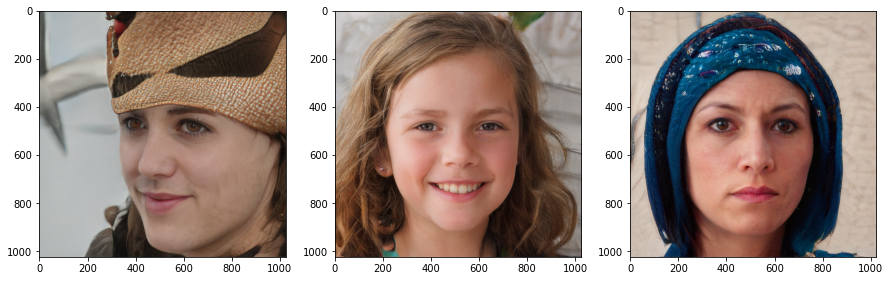

In [237]:
plt.figure(figsize=(15,15))
for i,img in enumerate(imgtest.imgs):
      plt.subplot(1,3,i+1)
      plt.imshow(img)
      

In [194]:

Gs.print_layers()


Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

In [238]:
src_dlatents=[]
for i in range(number_imgs):
  src_latents=imgtest.latentz[i]
  src_dlatents.append(Gs.components.mapping.run(src_latents, None))

In [239]:
#this is the concatenation of the mappings of the latent space
#which acts as the intermediate latent code W
#This space is used for the embedding
print(src_dlatents[0].shape)

(1, 18, 512)


In [240]:
src_dlatents1=[]
src_dlatents2=[]
for i in range(number_imgs):
  src_dlatents1.append(src_dlatents[i]+0.2)
  src_dlatents2.append(src_dlatents[i]+0.4)

In [241]:
manip1=[]
manip2=[]
for i in range(number_imgs):
  manip1.append(Gs.components.synthesis.run(src_dlatents1[i], randomize_noise=False, output_transform=fmt))
  manip2.append(Gs.components.synthesis.run(src_dlatents2[i], randomize_noise=False, output_transform=fmt))

In [242]:
print(manip1[2].shape)

(1, 1024, 1024, 3)


In [243]:
for i in range(number_imgs):
  manip1[i]=np.squeeze(manip1[i],axis=0)
  manip2[i]=np.squeeze(manip2[i],axis=0)

In [246]:
test=[]
for i in range(number_imgs):
  test.append(imgtest.imgs[i])
  test.append(manip1[i])
  test.append(manip2[i])

titles=["original","dlatent+0.2","dlatent+0.4"]*number_imgs

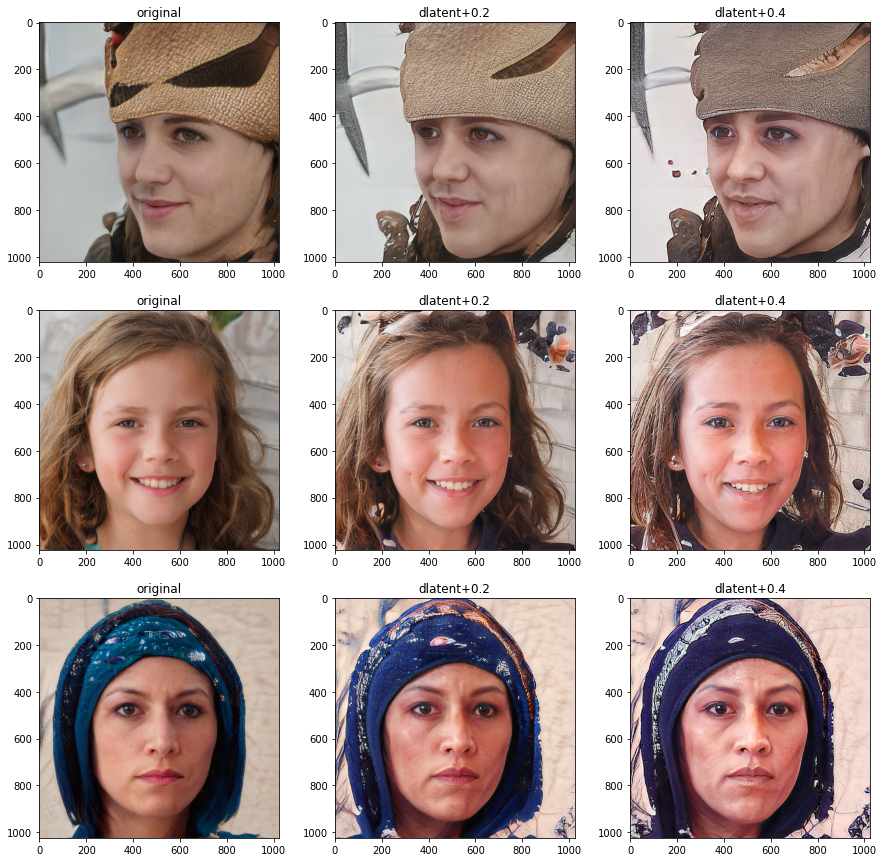

In [247]:
plt.figure(figsize=(15,15))
for i,img in enumerate(test):
      plt.subplot(3,3,i+1)
      plt.imshow(img)
      plt.title(titles[i])
    

In [221]:
import IPython.display
import time
from PIL import Image
def morphing(w1,w2):
  k=0
  imgset=[]
  while k<=1:
    w=k*(w1)+(1-k)*w2
    img=np.squeeze(Gs.components.synthesis.run(w, randomize_noise=False, output_transform=fmt), axis=0)
    imgset.append(img)
    IPython.display.clear_output(wait=True)
    IPython.display.display_png(Image.fromarray(img))
    k=k+0.1
    time.sleep(1.5)
  return imgset




In [222]:
womanimg=[]
manimg=[]
lat1,lat2=[],[]
woman=generator(1,womanimg,lat1,5)
man=generator(1,manimg,lat2,23)
woman.generate()
man.generate()

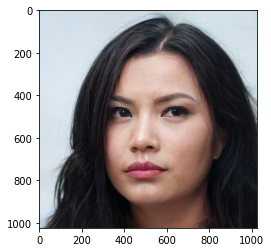

In [223]:
plt.imshow(woman.imgs[0])

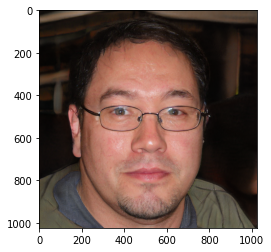

In [224]:
plt.imshow(man.imgs[0])

In [225]:
src_latents=woman.latentz[0]
w1=Gs.components.mapping.run(src_latents, None)
src_latents=man.latentz[0]
w2=Gs.components.mapping.run(src_latents, None)

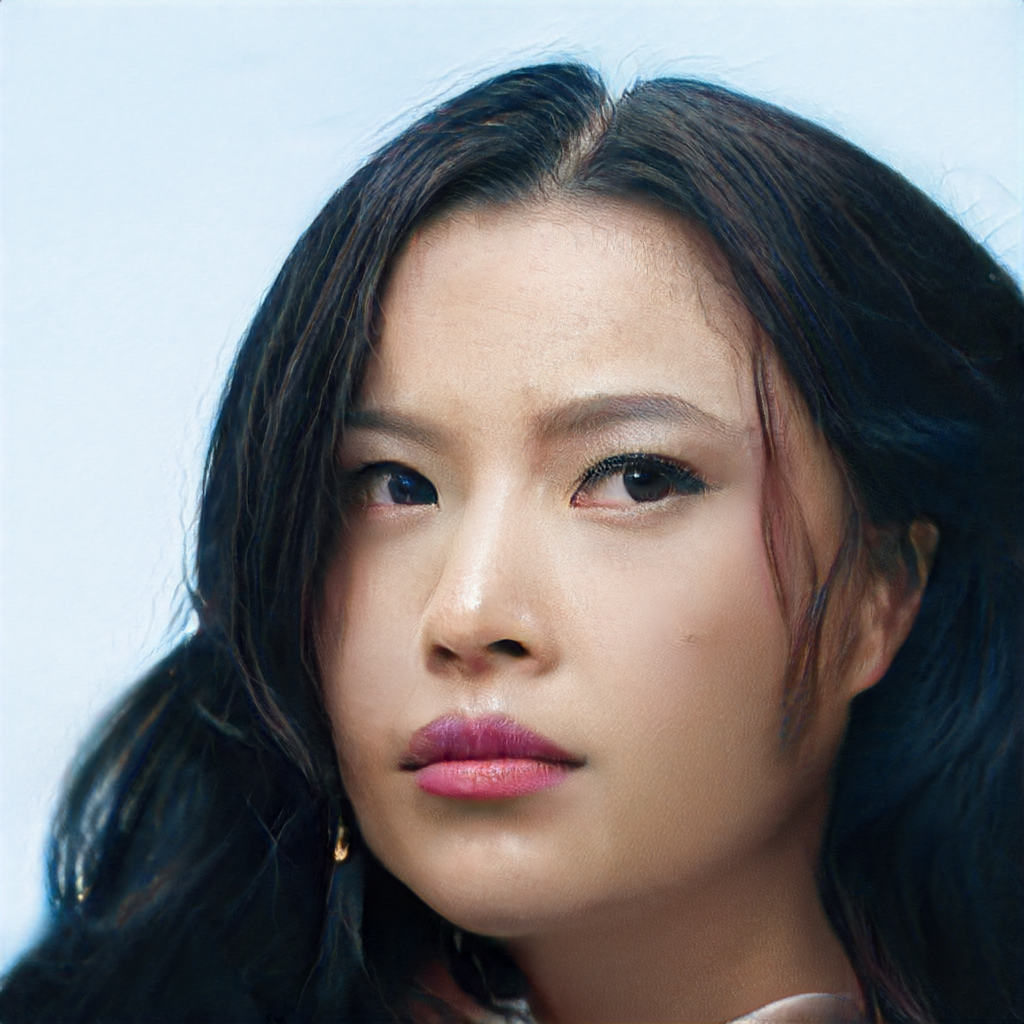

In [226]:
imgset=morphing(w1,w2)

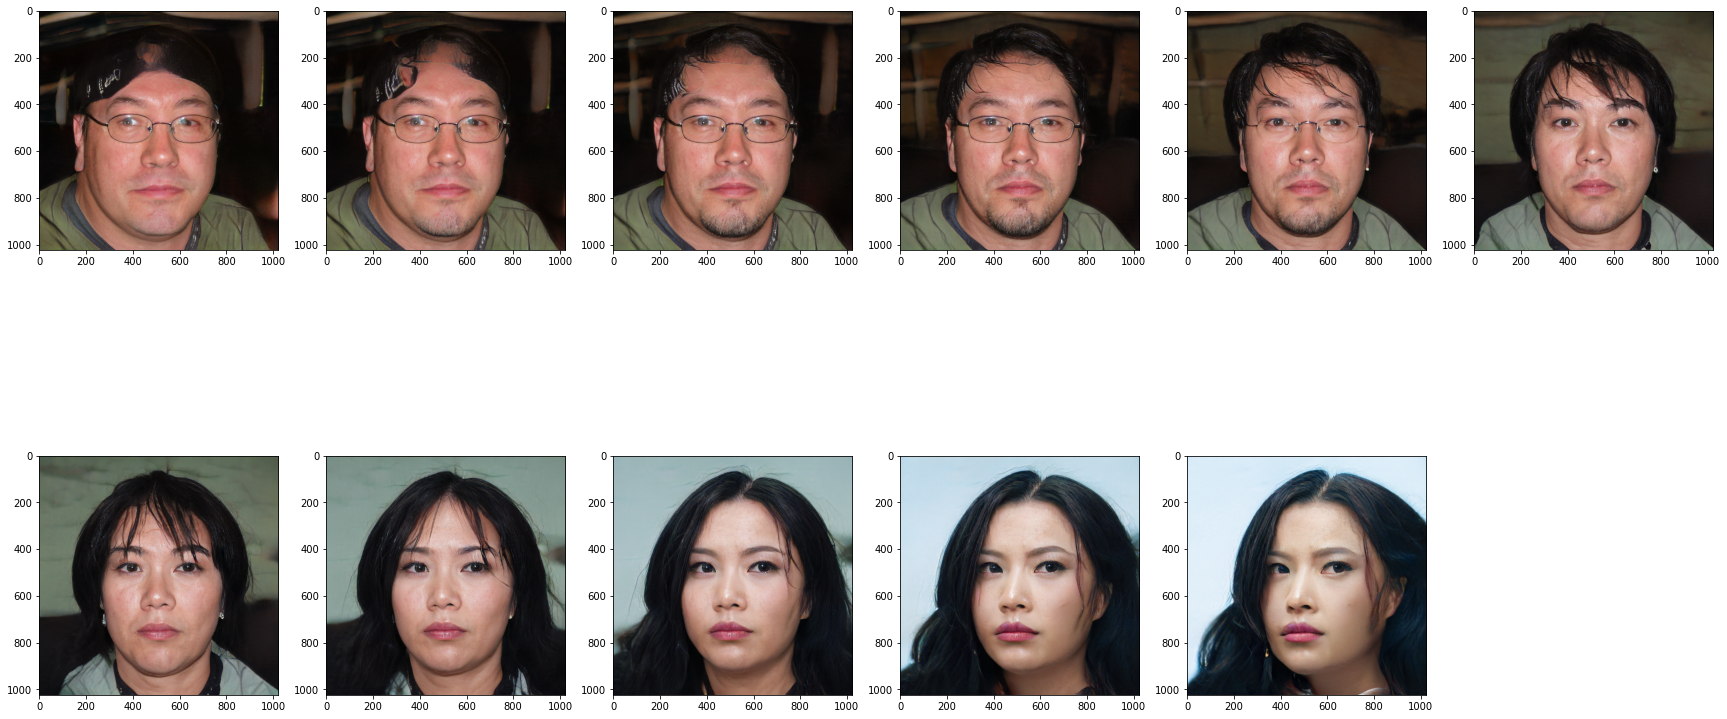

In [228]:
plt.figure(figsize=(30,15))
for i,img in enumerate(imgset):
      plt.subplot(2,6,i+1)
      plt.imshow(img)
    